In [49]:
import numpy as np
import matplotlib.pyplot as plt
from prose import FitsManager, Sequence, blocks, FITSImage, Fluxes
from astropy.visualization import ZScaleInterval
from utils import find_nearest_idx

In [4]:
fits_folder = "./data/images/20250410"
fm = FitsManager(fits_folder)
fm

Parsing FITS:   0%|          | 0/332 [00:00<?, ?it/s]

,date,telescope,filter,type,target,width,height,files
id,,,,,,,,
1,2025-04-10,HPP-ETHZ,G,bias,,2916,2187,10
3,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,58
8,2025-04-10,HPP-ETHZ,G,flat,,2916,2187,50
22,2025-04-10,HPP-ETHZ,G,light,HAT-P-36b,2916,2187,104
23,2025-04-10,HPP-ETHZ,G,light,TrES-2b,2916,2187,110


In [5]:
files = fm.observation_files(i = 23)

,date,telescope,filter,type,target,width,height,exposure,files
id,,,,,,,,,
23,2025-04-10,HPP-ETHZ,G,light,TrES-2b,2916,2187,120.000000,110
3,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,17.000000,10
4,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,34.000000,10
5,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,51.000000,10
6,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,68.000000,10
7,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,85.000000,10
2,2025-04-10,HPP-ETHZ,G,dark,,2916,2187,102.000000,8
1,2025-04-10,HPP-ETHZ,G,bias,,2916,2187,0.000000,10
8,2025-04-10,HPP-ETHZ,G,flat,,2916,2187,1.780586,11


  0%|          | 0/1 [00:00<?, ?images/s]

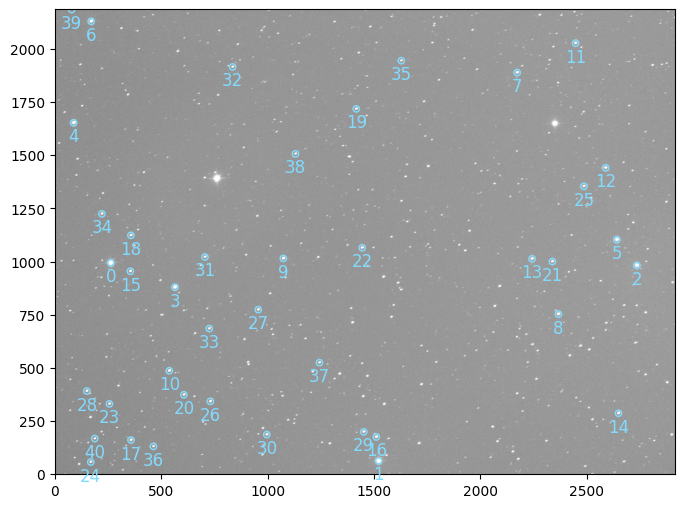

In [46]:
# reference image is middle image
reference_image = FITSImage(files["images"][len(files["images"]) // 2])

calibration_sequence = Sequence(
    [
        blocks.Calibration(
            darks=files["darks"][::2], bias=files["bias"][::2], flats=files["flats"][::2]
        ),
        blocks.Trim(),
        blocks.PointSourceDetection(n=41, saturation=60000),  # stars detection
        blocks.catalogs.PlateSolve(debug=False),
        blocks.catalogs.GaiaCatalog(limit=50),
        blocks.Cutouts(41),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.psf.Gaussian2D(),  # modeling EPSF
    ]
)

calibration_sequence.run(reference_image)
reference_image.show()

blocks.catalogs.GaiaCatalog()

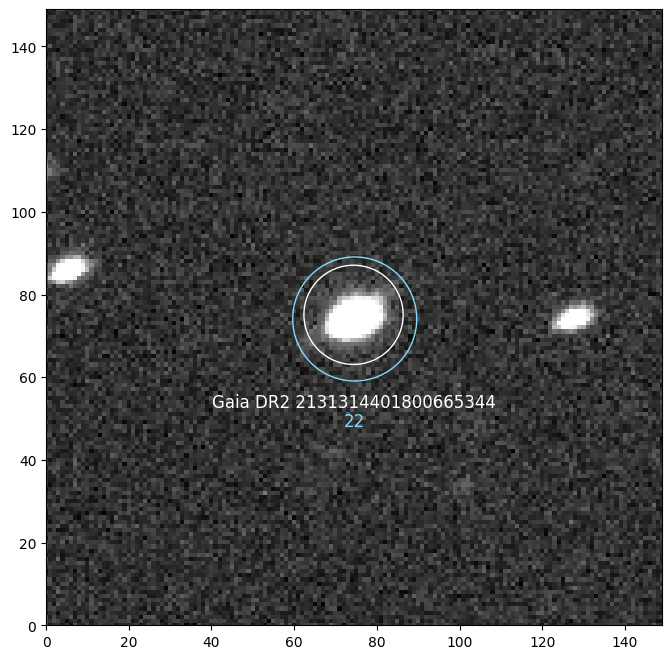

In [36]:
gaias = reference_image.catalogs["gaia"]["id"]
gaia_id = "Gaia DR2 2131314401800665344"
match_id = np.where(gaias == gaia_id)
match_coords = reference_image.catalogs["gaia"][["x", "y"]].values[match_id]
target_idx = find_nearest_idx(reference_image.sources.coords, match_coords)

cutout = reference_image.cutout(target_idx, 150, reset_index=False)
cutout.show()
cutout.plot_catalog("gaia", label=True, color="w")

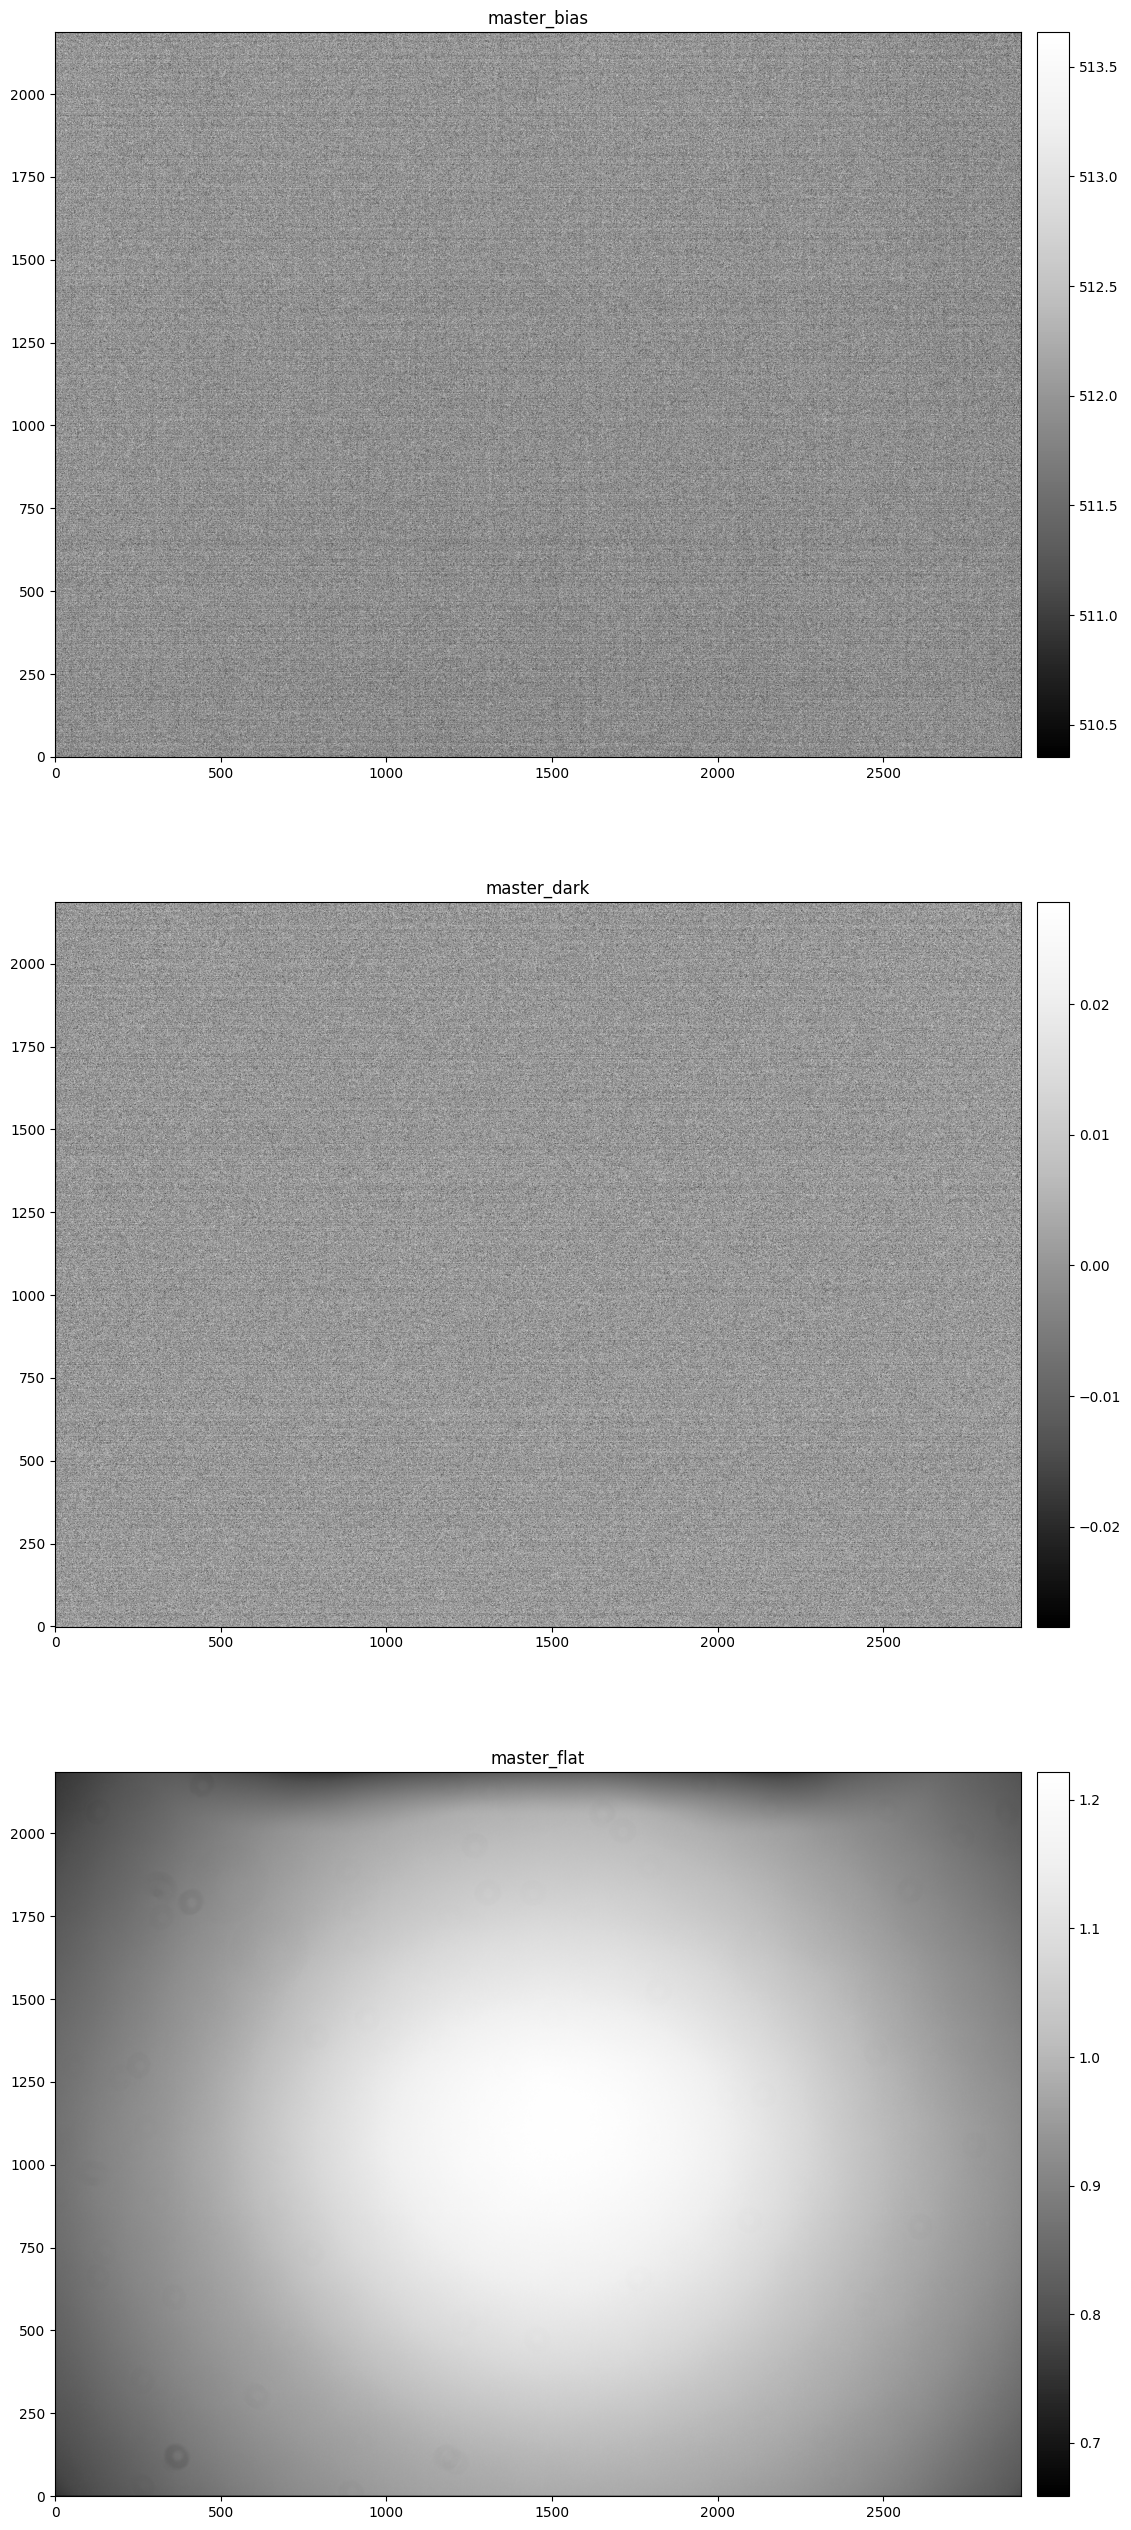

In [37]:
masters = calibration_sequence[0]

fig, ax = plt.subplots(3,1, figsize=(16,32))

for i in range(3):
    if i == 0:
        data = masters.master_bias
        title = 'master_bias'
        contrast = 0.5
    elif i == 1:
        data = masters.master_dark
        title = 'master_dark'
        contrast = 0.5
    elif i == 2:
        data = masters.master_flat
        title = 'master_flat'
        contrast = 0.5

    interval = ZScaleInterval(contrast=contrast)
    vmin, vmax = interval.get_limits(data)
    
    # vmin = np.nanmedian(data)
    # vmax = vmax = vmin * (1 + contrast) / (1 - contrast)
    im = ax[i].imshow(
        data, cmap="Greys_r", origin="lower", vmin=vmin, vmax=vmax,
    )
    ax[i].set_title(title)
    cax = fig.add_axes([ax[i].get_position().x1+0.01,ax[i].get_position().y0,0.02,ax[i].get_position().height])
    fig.colorbar(im, cax=cax)

In [38]:
photometry_sequence = Sequence(
    [
        calibration_sequence[0],  # calibration block (same as above)
        blocks.Trim(),
        blocks.PointSourceDetection(n=20, minor_length=8),  # fewer stars detection
        blocks.Cutouts(41),  # stars cutouts
        blocks.MedianEPSF(),  # building EPSF
        blocks.Gaussian2D(reference_image),  # modeling EPSF with initial guess
        blocks.ComputeTransformTwirl(reference_image),  # compute alignment
        blocks.AlignReferenceSources(reference_image),  # alignment
        blocks.CentroidQuadratic(),  # centroiding
        blocks.AperturePhotometry(),  # aperture photometry
        blocks.AnnulusBackground(),  # annulus background
        blocks.GetFluxes(
            "fwhm",
            airmass=lambda im: im.header["AIRMASS"],
            dx=lambda im: im.transform.translation[0],
            dy=lambda im: im.transform.translation[1],
        ),
    ]
)

In [40]:
photometry_sequence.run(files["images"])

  0%|          | 0/110 [00:00<?, ?images/s]

In [41]:
raw_fluxes: Fluxes = photometry_sequence[-1].fluxes
fluxes = raw_fluxes.copy()

fluxes.target = target_idx

(0.98, 1.02)

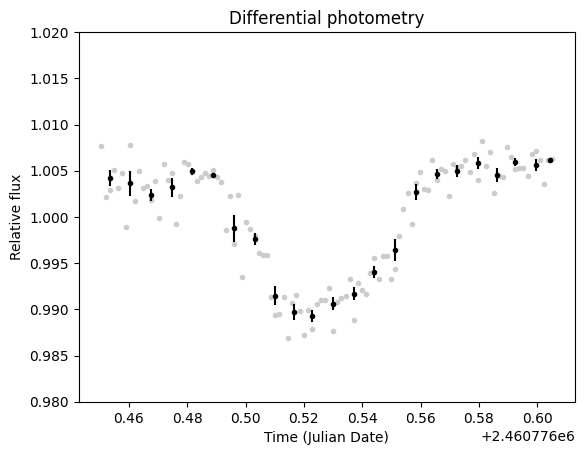

In [42]:
# a bit of cleaning
nan_stars = np.any(np.isnan(fluxes.fluxes), axis=(0, 2))  # stars with nan fluxes
fluxes = fluxes.mask_stars(~nan_stars)  # mask nans stars
fluxes = fluxes.sigma_clipping_data(bkg=3, fwhm=3)  # sigma clipping

# differential photometry
diff_flux = fluxes.autodiff()

diff_flux.plot()
diff_flux.bin(10 / (24 * 60), estimate_error=True).errorbar()
plt.xlabel("Time (Julian Date)")
plt.ylabel("Relative flux")
plt.title("Differential photometry")
plt.ylim(0.98, 1.02)

In [43]:
diff_flux.comparisons, diff_flux.aperture, diff_flux.weights[diff_flux.aperture]

(array([ 0,  3,  9,  8,  6, 15,  5]),
 17,
 array([830.11522221,   0.        ,   0.        , 823.9979383 ,
          0.        , 498.29160057, 547.08724222,   0.        ,
        562.74981434, 581.60420307,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        , 508.5977756 ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ]))

In [44]:
diff_flux.save(f"./{ref.label}.flux")